# Advanced Lane Lines

In [1]:
import numpy as np
import os
import cv2
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual, SelectionSlider, IntSlider, FloatSlider
%matplotlib inline

## Camera calibration

In [2]:
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(f'Camera matrix:\n{mtx} \nDistortion coefficients: {dist}')

Camera matrix:
[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
Distortion coefficients: [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


## Compute perspective transformations

In [3]:
def get_roi(img_shape, roi_top_ratio, roi_top_width_ratio, roi_bottom_width_ratio=1):
    """
    Region of interest is defined as an isosceles trapezoid, with the base being the entire botton of the image.
    We then only define its height (roi_top) and the width of the top edge (roi_top_width)
    """
    height, width = img_shape[0], img_shape[1]

    roi_top = roi_top_ratio * height
    roi_top_width = roi_top_width_ratio * width
    roi_bottom_width = roi_bottom_width_ratio * width
    roi = np.array([
        [(width - roi_bottom_width) // 2, height],
        [(width - roi_top_width) // 2, roi_top],
        [(width + roi_top_width) // 2, roi_top],
        [(width + roi_bottom_width) // 2, height]], dtype=np.int32)
    return roi


In [4]:
test_image = cv2.imread('test_images/straight_lines1.jpg')

def compute_perspective_transform(source, destination):
    transform = cv2.getPerspectiveTransform(source, destination)
    inverse_transform = cv2.getPerspectiveTransform(destination, source)
    return transform, inverse_transform

def get_shapes_from_params(roi_top, roi_top_width, roi_bottom_width, t_width, t_height):
    h, w = test_image.shape[0], test_image.shape[1]
    source = get_roi((h, w), roi_top, roi_top_width, roi_bottom_width).astype("float32")
    target_width = t_width * w
    target_height = t_height * h
    destination = np.array([
        [(w-target_width)//2, (h+target_height)//2], 
        [(w-target_width)//2, (h-target_height)//2], 
        [(w+target_width)//2, (h-target_height)//2], 
        [(w+target_width)//2, (h+target_height)//2]], dtype = "float32")
    return source, destination

def preview_params(roi_top, roi_top_width, roi_bottom_width, t_width, t_height):
    
    src, dst = get_shapes_from_params(roi_top, roi_top_width, roi_bottom_width, t_width, t_height)
    M, Minv = compute_perspective_transform(src, dst)
    warped = cv2.warpPerspective(test_image, M, (test_image.shape[1], test_image.shape[0]), flags=cv2.INTER_LINEAR)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    ax1.add_patch(patches.Polygon(src,linewidth=1,edgecolor='r',facecolor='none'))
    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.add_patch(patches.Polygon(dst,linewidth=1,edgecolor='r',facecolor='none'))

w = interactive(preview_params, {'manual': False}, 
                roi_top=FloatSlider(0.64, min=0.0, max=1.0, step=0.01), 
                roi_top_width=FloatSlider(0.09, min=0.0, max=1.0, step=0.01),
                roi_bottom_width=FloatSlider(0.69, min=0.0, max=1.0, step=0.01),
                t_width=FloatSlider(0.59, min=0.0, max=1.0, step=0.01),
                t_height=FloatSlider(0.96, min=0.0, max=1.0, step=0.01))
display(w)

interactive(children=(FloatSlider(value=0.64, description='roi_top', max=1.0, step=0.01), FloatSlider(value=0.…

In [5]:
src, dst = get_shapes_from_params(
    w.kwargs['roi_top'], w.kwargs['roi_top_width'], w.kwargs['roi_bottom_width'], 
    w.kwargs['t_width'], w.kwargs['t_height'])

print(f'src:\n{src}\ndst:\n{dst}')
M, Minv = compute_perspective_transform(src, dst)
print(f"M transform:\n{M}\nMinv transform:\n{Minv}")

src:
[[ 198.  720.]
 [ 582.  460.]
 [ 697.  460.]
 [1081.  720.]]
dst:
[[ 262.  705.]
 [ 262.   14.]
 [1017.   14.]
 [1017.  705.]]
M transform:
[[-6.07025790e-01 -1.51875812e+00  1.02769299e+03]
 [-4.20672850e-16 -1.92004762e+00  8.81927454e+02]
 [-5.41442279e-19 -2.37491496e-03  1.00000000e+00]]
Minv transform:
[[ 1.49680244e-01 -7.91000234e-01  5.43779484e+02]
 [ 1.07419809e-16 -5.20820415e-01  4.59325823e+02]
 [ 2.31477305e-19 -1.23690420e-03  1.00000000e+00]]


## Color filtering

In [6]:
def color_filter(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Isolate the yellow color values
    yellow_mask = cv2.inRange(hsv, (20, 100, 100), (25, 255, 255))

    # Isolate the white color values
    white_mask = cv2.inRange(hsv, (0, 0, 215), (180, 32, 255))
    
    binary = sxbinary | white_mask | yellow_mask
    
    return binary

In [7]:
test_images = [
    cv2.imread('test_images/straight_lines1.jpg'), 
    cv2.imread('test_images/test1.jpg'),
    cv2.imread('test_images/test2.jpg'),
    cv2.imread('test_images/test3.jpg'),
    cv2.imread('test_images/test4.jpg'),
    cv2.imread('test_images/test5.jpg'),
    cv2.imread('test_images/test6.jpg'),
    cv2.imread('error_images/latest.jpg'),
]

def preview_params(s_thresh_min, s_thresh_max, sx_thresh_min, sx_thresh_max):
    fig, axes = plt.subplots(math.ceil(len(test_images)/2), 2, figsize=(20,20))
    for test_image, ax in zip(test_images, [b for a in axes for b in a]):
        ax.imshow(color_filter(test_image, (s_thresh_min, s_thresh_max), (sx_thresh_min, sx_thresh_max)), cmap='gray')
#out = process_image(test_image, mtx, dist, M, Minv, s_thresh, sx_thresh)
w = interactive(preview_params, {'manual': False}, 
                s_thresh_min=IntSlider(170, 0 ,255), s_thresh_max=IntSlider(250, 0, 255), 
                sx_thresh_min=IntSlider(60, 0, 255), sx_thresh_max=IntSlider(150, 0, 255))
display(w)

interactive(children=(IntSlider(value=170, description='s_thresh_min', max=255), IntSlider(value=250, descript…

In [8]:
s_thresh = (w.kwargs['s_thresh_min'], w.kwargs['s_thresh_max'])
sx_thresh = (w.kwargs['sx_thresh_min'], w.kwargs['sx_thresh_max'])
print(s_thresh, sx_thresh)

(170, 250) (60, 150)


## Line finding

In [9]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    else:
        left_fitx = []

    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        right_fitx = []
        
    return left_fitx, right_fitx, ploty

def draw_lane( x_left, x_right, y, img_shape):
    mask = np.zeros(img_shape, dtype=np.uint8)
    points = np.array([list(zip(x_left, y))+list(zip(x_right, y))[::-1]], dtype="int")
    if len(points[0]) > 0:
        cv2.fillPoly(mask, points, (0, 255, 0))
    return mask

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

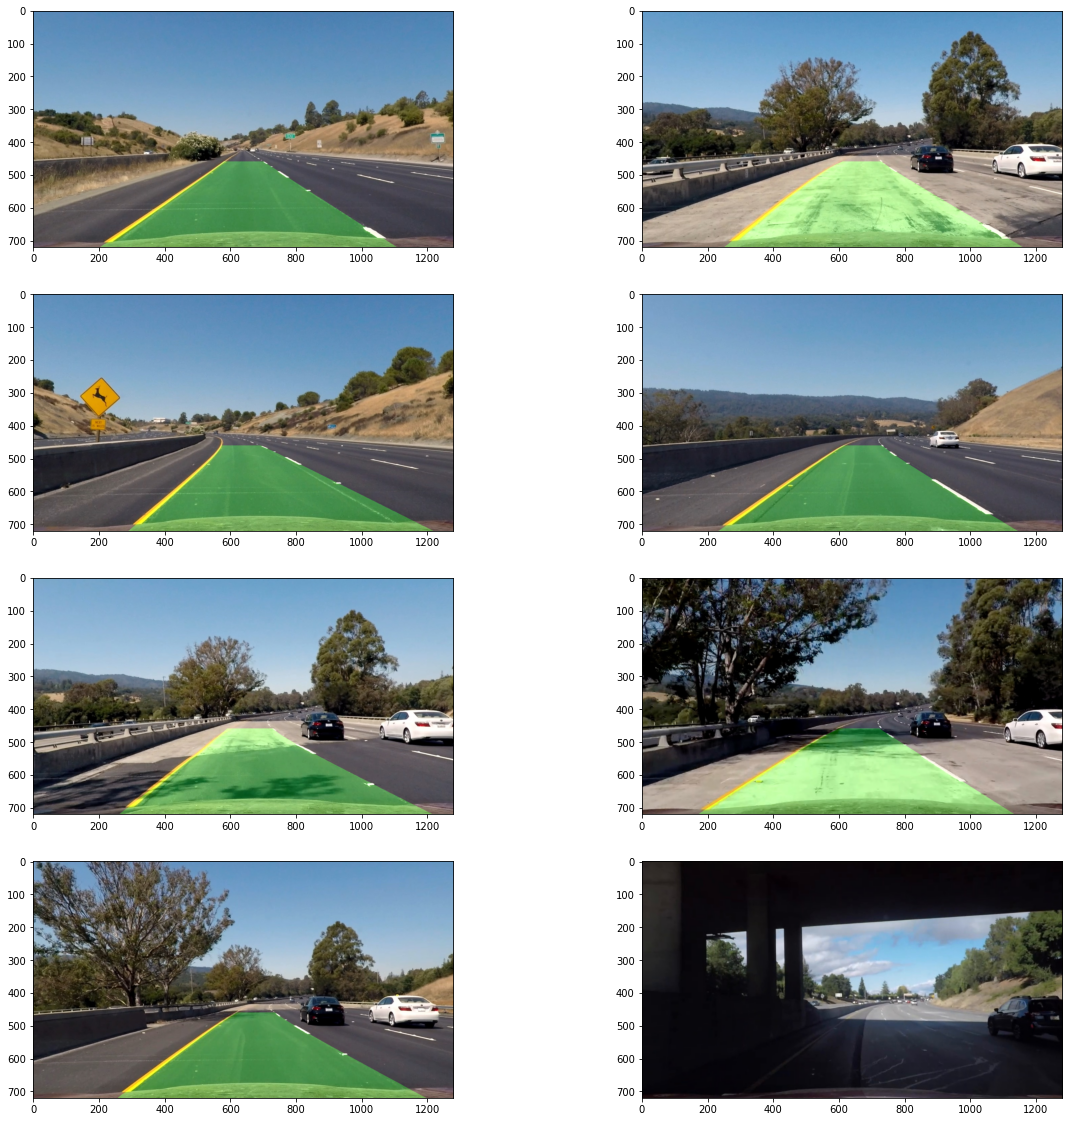

In [10]:
def process_image(image, camera_matrix, distortion_coeff, warp, warp_inv, s_thresh, sx_thresh):
    orig = np.copy(image)
    # undistort image using camera parameters computed during calibration
    undistorted = cv2.undistort(orig, mtx, dist, None, mtx)
    # binarize image
    img = color_filter(undistorted, s_thresh, sx_thresh)
    # change perspective
    img = cv2.warpPerspective(img, warp, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # find lines in warped binary image
    left_fitx, right_fitx, ploty = fit_polynomial(img)
    # Plots the left and right polynomials on the lane lines
    line_img = draw_lane(left_fitx, right_fitx, ploty, undistorted.shape)
    # change perspective back
    line_img = cv2.warpPerspective(line_img, warp_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # merge images
    out_img = weighted_img(undistorted, line_img, α=0.3)
    return out_img

fig, axes = plt.subplots(math.ceil(len(test_images)/2), 2, figsize=(20,20))
for test_image, ax in zip(test_images, [b for a in axes for b in a]):
    out = process_image(test_image, mtx, dist, M, Minv, s_thresh, sx_thresh)
    ax.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

In [11]:
source_dir = 'test_images'
target_dir = 'output_images'

for img_file in os.listdir(source_dir):
    img = cv2.imread(os.path.join(source_dir, img_file))
    processed_img = process_image(img, mtx, dist, M, Minv, s_thresh, sx_thresh)
    cv2.imwrite(os.path.join(target_dir, img_file), processed_img)

In [12]:
out_video = 'output_videos'
if not os.path.exists(out_video):
    os.mkdir(out_video)

In [13]:
project_output = f'{out_video}/project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')

count = 0
error_dir = 'error_images'
def debug_process_image(img):
    """
    This wrapper saves problematic images, to assist in finetuning
    """
    global count
    try:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out = process_image(img, mtx, dist, M, Minv, s_thresh, sx_thresh)
        #cv2.imwrite(os.path.join(error_dir, f'o{count}.jpg'), img)
        #cv2.imwrite(os.path.join(error_dir, f'p{count}.jpg'), out)
        count += 1
        return cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    except Exception as ex:
        print(ex)
        print(f'there was an error while processing frame {count}, we need to further finetune')
        if not os.path.exists(error_dir):
            os.mkdir(error_dir)
        cv2.imwrite(os.path.join(error_dir, 'latest.jpg'), img)
        
project_clip = clip1.fl_image(debug_process_image)
%time project_clip.write_videofile(project_output, audio=False)

t:   0%|▌                                                                                                                                                                                                                        | 3/1260 [00:00<01:07, 18.52it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
Wall time: 1min 44s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Advanced challenge

In [15]:
challenge_output = f'{out_video}/challenge_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
count = 0
challenge_clip = clip2.fl_image(debug_process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   1%|█▎                                                                                                                                                                                                                        | 3/485 [00:00<00:24, 19.61it/s, now=None]

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
Wall time: 38.6 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))